In [3]:
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import gc
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

In [ ]:
import tensorflow_addons as tfa
import tensorflow_similarity as tfsim
import tensorflow as tf
import tensorflow_datasets as tfds

/Users/cindyliuyn/Documents/FourthBrain-Capstone/retina-oct-images/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Your CPU supports instructions that this binary was not compiled to use: AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [ ]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

In [ ]:
base_dir = os.path.join('OCT2017/')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def load_images(base_dir, data_type, batch_size):
    data_path = os.path.join(base_dir, data_type + '/')
    data_gen = ImageDataGenerator(rescale=1. / 255)
    return next(data_gen.flow_from_directory(data_path, target_size=(150, 150), class_mode='categorical',
                                        batch_size=batch_size))

In [ ]:
train_images, train_labels = load_images(base_dir, 'train', 10000)

Found 83484 images belonging to 4 classes.


In [ ]:
print(train_images.dtype, train_images.shape)
print(train_labels.dtype, train_labels.shape)

float32 (10000, 150, 150, 3)
float32 (10000, 4)


In [ ]:
test_images, test_labels = load_images(base_dir, 'test', 500)

Found 968 images belonging to 4 classes.


In [ ]:
print(test_images.dtype, test_images.shape)
print(test_labels.dtype, test_labels.shape)

float32 (500, 150, 150, 3)
float32 (500, 4)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2)

In [ ]:
print(
    tabulate(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
        ],
        headers=["Examples", "Labels"],
    )
)

       Examples             Labels
-----  -------------------  ---------
train  (8000, 150, 150, 3)  (8000, 4)
val    (2000, 150, 150, 3)  (2000, 4)


In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
ALGORITHM = "simsiam"  # @param ["barlow", "simsiam", "simclr"]

IMG_SIZE = 150

if ALGORITHM == "simsiam":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 3e-2 * int(BATCH_SIZE / 256)
    WARMUP_LR = 0.0
    WARMUP_STEPS = 0
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "barlow":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_LR = 0.0
    WARMUP_STEPS = 1000
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "simclr":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule, see section B.1 in the paper.
    TEMPERATURE = 0.5  # Tuned for CIFAR10, see section B.9 in the paper.
    DIM = 2048  # The layer size for the projector and predictor models.

In [ ]:
def img_scaling(img):
    return tf.keras.applications.imagenet_utils.preprocess_input(
        img, 
        data_format=None, 
        mode='torch')

@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.

    The SimSiam augmentations are based on the SimCLR augmentations, but have
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.

    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.

    returns:
        A single image tensor of shape (H, W, C) with values between -1.0 and 1.0.
    """
#     # random resize and crop. Increase the size before we crop.
#     img = tfsim.augmenters.simclr.crop_and_resize(
#         img, IMG_SIZE, IMG_SIZE, area_range=area_range
#     )
    
#     # The following transforms expect the data to be [0, 1]
#     img /= 255.
                       
    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.simclr.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "simclrv2",
        )

    img = tfsim.augmenters.simclr.random_apply(_jitter_transform, p=0.8, x=img)

    # random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.simclr.to_grayscale(x)

    img = tfsim.augmenters.simclr.random_apply(_grascayle_transform, p=0.2, x=img)

    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.simclr.random_blur(img, p=0.5)

    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    
    # scale the data back to [0, 255]
    img = img * 255.
    img = tf.clip_by_value(img, 0., 255.)

    return img


@tf.function()
def process(img):
    view1 = simsiam_augmenter(img, blur=False)
    view1 = img_scaling(view1)
    view2 = simsiam_augmenter(img, blur=False)
    view2 = img_scaling(view2)
    return (view1, view2)


train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.repeat()
val_ds = val_ds.shuffle(1024)
val_ds = val_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

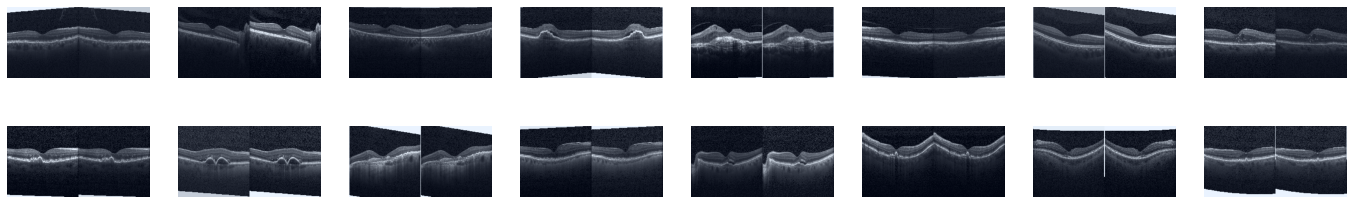

In [ ]:
display_imgs = next(train_ds.as_numpy_iterator())
max_pixel = np.max([display_imgs[0].max(), display_imgs[1].max()])
min_pixel = np.min([display_imgs[0].min(), display_imgs[1].min()])

tfsim.visualization.visualize_views(
    views=display_imgs,
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)

In [ ]:
# Try use ResNet 50 too 
def get_backbone(img_size, activation="relu", preproc_mode="torch"):
    input_shape = (img_size, img_size, 3)

    backbone = tfsim.architectures.ResNet18Sim(
        input_shape,
        include_top=False,  # Take the pooling layer as the output.
        pooling="avg",
    )
    return backbone


backbone = get_backbone(IMG_SIZE)
backbone.summary()

Model: "resnet18sim"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet18 (Functional)       (None, 19, 19, 512)       11182784  
                                                                 
 avg_pool (GlobalAveragePool  (None, 512)              0         
 ing2D)                                                          
                                                                 
Total params: 11,182,784
Trainable params: 11,173,056
Non-trainable params: 9,728
_________________________________________________________________


In [ ]:
def get_projector(input_dim, dim, activation="relu", num_layers: int = 3):
    inputs = tf.keras.layers.Input((input_dim,), name="projector_input")
    x = inputs

    for i in range(num_layers - 1):
        x = tf.keras.layers.Dense(
            dim,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.LecunUniform(),
            name=f"projector_layer_{i}",
        )(x)
        x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name=f"batch_normalization_{i}")(x)
        x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(x)
    x = tf.keras.layers.Dense(
        dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="projector_output",
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5,
        center=False,  # Page:5, Paragraph:2 of SimSiam paper
        scale=False,  # Page:5, Paragraph:2 of SimSiam paper
        name=f"batch_normalization_ouput",
    )(x)
    # Metric Logging layer. Monitors the std of the layer activations.
    # Degnerate solutions colapse to 0 while valid solutions will move
    # towards something like 0.0220. The actual number will depend on the layer size.
    o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    projector = tf.keras.Model(inputs, o, name="projector")
    return projector


projector = get_projector(input_dim=backbone.output.shape[-1], dim=DIM, num_layers=2)
projector.summary()

Model: "projector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projector_input (InputLayer  [(None, 512)]            0         
 )                                                               
                                                                 
 projector_layer_0 (Dense)   (None, 2048)              1048576   
                                                                 
 batch_normalization_0 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 relu_activation_0 (Activati  (None, 2048)             0         
 on)                                                             
                                                                 
 projector_output (Dense)    (None, 2048)              4194304   
                                                         

In [ ]:
def get_predictor(input_dim, hidden_dim=512, activation="relu"):
    inputs = tf.keras.layers.Input(shape=(input_dim,), name="predictor_input")
    x = inputs

    x = tf.keras.layers.Dense(
        hidden_dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_layer_0",
    )(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name="batch_normalization_0")(x)
    x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

    x = tf.keras.layers.Dense(
        input_dim,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_output",
    )(x)
    # Metric Logging layer. Monitors the std of the layer activations.
    # Degnerate solutions colapse to 0 while valid solutions will move
    # towards something like 0.0220. The actual number will depend on the layer size.
    o = tfsim.layers.ActivationStdLoggingLayer(name="pred_std")(x)
    predictor = tf.keras.Model(inputs, o, name="predictor")
    return predictor


predictor = get_predictor(input_dim=DIM, hidden_dim=512)
predictor.summary()

Model: "predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predictor_input (InputLayer  [(None, 2048)]           0         
 )                                                               
                                                                 
 predictor_layer_0 (Dense)   (None, 512)               1048576   
                                                                 
 batch_normalization_0 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 relu_activation_0 (Activati  (None, 512)              0         
 on)                                                             
                                                                 
 predictor_output (Dense)    (None, 2048)              1050624   
                                                         

In [ ]:
if ALGORITHM == "simsiam":
    loss = tfsim.losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        predictor=predictor,  # NOTE: simiam requires predictor model.
        algorithm=ALGORITHM,
        name=ALGORITHM,
    )
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    wd_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=WEIGHT_DECAY,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    optimizer = tfa.optimizers.SGDW(learning_rate=lr_decayed_fn, weight_decay=wd_decayed_fn, momentum=0.9)
elif ALGORITHM == "barlow":
    loss = tfsim.losses.Barlow(name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm="barlow",
    )
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
elif ALGORITHM == "simclr":
    loss = tfsim.losses.SimCLRLoss(name=ALGORITHM, temperature=TEMPERATURE)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm=ALGORITHM,
    )
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
else:
    raise ValueError(f"{ALGORITHM} is not supported.")

In [ ]:
contrastive_model.compile(
    optimizer=optimizer,
    loss=loss,
)

In [ ]:
DATA_PATH = Path("tfsim_contrastive_model")
if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=True)

In [ ]:
# log_dir = DATA_PATH / "models" / "logs" / f"{loss.name}_{time.time()}"
# chkpt_dir = DATA_PATH / "models" / "checkpoints" / f"{loss.name}_{time.time()}"


# evb = tfsim.callbacks.EvalCallback(
#     img_scaling(tf.cast(x_query, tf.float32)),
#     y_query,
#     img_scaling(tf.cast(x_index, tf.float32)),
#     y_index,
#     metrics=["binary_accuracy"],
#     k=1,
#     tb_logdir=log_dir,
# )
# tbc = tf.keras.callbacks.TensorBoard(
#     log_dir=log_dir,
#     histogram_freq=1,
#     update_freq=100,
# )
# mcp = tf.keras.callbacks.ModelCheckpoint(
#     filepath=chkpt_dir,
#     monitor="loss",
#     mode="min",
#     save_best_only=True,
#     save_weights_only=True,
# )

In [ ]:
history = contrastive_model.fit(
    train_ds,
    epochs=PRE_TRAIN_EPOCHS,
    steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[],
)